# Movie Script Generation

In this project, you'll generate your own [Avengers](https://en.wikipedia.org/wiki/Avengers) movie scripts using RNNs.  You'll be using part of the Avengers : Infinity Wars & EndGame Scripts.  The Neural Network you'll build will generate a new ,"fake" movie script, based on patterns it recognizes in this training data.

## Get the Data

The data is already provided for you in `./data/avengers_infinity.txt`,`./data/avengers_endgame.txt` and you're encouraged to open that file and look at the text. 
>* As a first step, we'll load in this data and look at some samples. And explore these data ;) 
* Then, you'll be tasked with defining and training an RNN to generate a new script!

In [3]:
# load in data
import os
import pickle
import torch

SPECIAL_WORDS = {'PADDING': '<PAD>'}

def load_data(path):
    """
    Load Dataset from File
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data

data_dir = './data/avengers_infinity.txt'
text = load_data(data_dir)

## Explore the Data
Play around with `view_line_range` to view different parts of the data. This will give you a sense of the data you'll be working with. You can see, for example, that it is all lowercase text, and each new line of dialogue is separated by a newline character `\n`.

In [4]:
view_line_range = (0, 10)

import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in text.split()})))

lines = text.split('\n')
print('Number of lines: {}'.format(len(lines)))
word_count_line = [len(line.split()) for line in lines]
print('Average number of words in each line: {}'.format(np.average(word_count_line)))

print()
print('The lines {} to {}:'.format(*view_line_range))
print('\n'.join(text.split('\n')[view_line_range[0]:view_line_range[1]]))

Dataset Stats
Roughly the number of unique words: 6321
Number of lines: 2608
Average number of words in each line: 9.235812883435583

The lines 0 to 10:
Asgardian PA: This is the Asgardian refugee vessel Statesman. We are under assault, I repeat, we are under assault - The engines are dead, life support failing. Requesting aid from any vessel within range. We are 22 jump points out of Asgard. [The voice becomes more desperate and pleading] Our crew is made up of Asgardian families, we have very few soldiers here. This is not a warcraft. I repeat, this is not a warcraft!

[Inside the ship, Ebony Maw walks among the bodies of dead Asgardians. Heimdall, badly wounded, reaches out as if he would stop Maw as he passes, but lacks the strength. Maw steps over them with no mind as he speaks, as if they were scattered pieces of dirty clothing on a bedroom floor.]

Ebony Maw: Hear me, and rejoice. You have had the privilege of being saved by the Great Titan.... You may think this is suffering...

In [5]:
import spacy 
nlp = spacy.load("en_core_web_md")

with open('./data/avengers_infinity.txt', 'r') as file:
    text = file.read()
    
doc = nlp(text)

MemoryError: Unable to allocate 130. MiB for an array with shape (33220, 1024) and data type float32

In [ ]:
import spacy
import numpy as np 
import matplotlib.pyplot as plt 
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

# map with frequency count
pos_count = {}
for token in doc:
    # ignore stop words
    if token.is_stop:
        continue

    # pos should be one of these:
    # 'VERB', 'NOUN', 'ADJ' or 'ADV'
    if token.pos_ == 'ADJ':
        if token.lemma_ in pos_count:
            pos_count[token.lemma_] += 1
        else:
            pos_count[token.lemma_] = 1

label = [x[0] for x in sorted(pos_count.items(), key=lambda kv: kv[1], reverse=True)[:10]]
no_verbs =  [x[1] for x in sorted(pos_count.items(), key=lambda kv: kv[1], reverse=True)[:10]]

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, no_verbs)
    plt.xlabel('Verbs')
    plt.ylabel('No of Occurence')
    plt.xticks(index, label,rotation=30)
    plt.title('top 10 Noun')
    plt.show()

plot_bar_x()

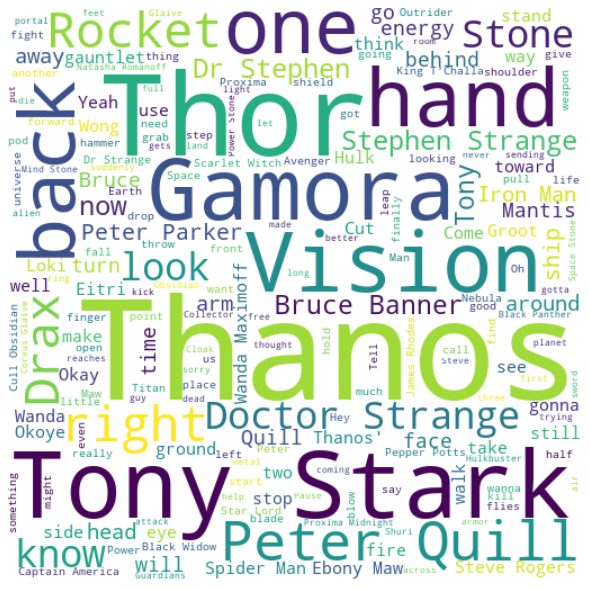

In [5]:
from wordcloud import WordCloud
word_count_text = WordCloud(width = 512,height = 512,background_color="white").generate(text)
plt.figure(figsize = (10, 8))
plt.imshow(word_count_text, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

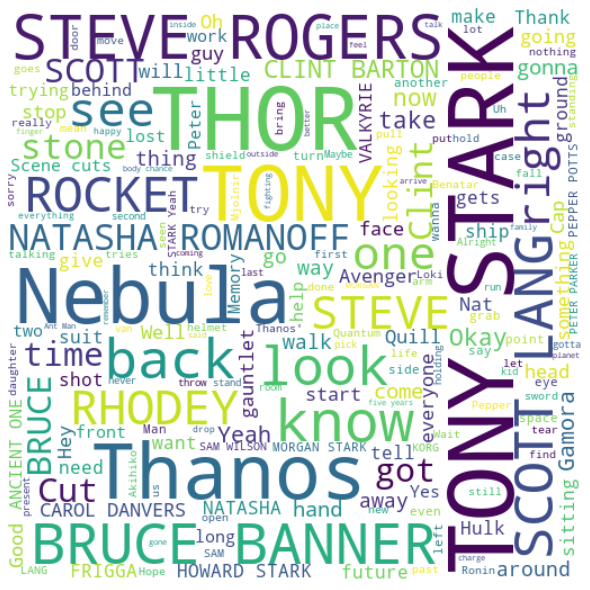

In [6]:
with open('./data/avengers_endgame.txt', 'r') as file:
    endgame = file.read()
    
word_count_text = WordCloud(width = 512,height = 512,background_color="white").generate(endgame)
plt.figure(figsize = (10, 8))
plt.imshow(word_count_text, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

---
## Implement Pre-processing Functions
The first thing to do to any dataset is pre-processing.  Implement the following pre-processing functions below:
- Lookup Table
- Tokenize Punctuation

### Lookup Table
To create a word embedding, you first need to transform the words to ids.  In this function, create two dictionaries:
- Dictionary to go from the words to an id, we'll call `vocab_to_int`
- Dictionary to go from the id to word, we'll call `int_to_vocab`

Return these dictionaries in the following **tuple** `(vocab_to_int, int_to_vocab)`

In [7]:
def create_lookup_tables(text):
    """
    Create lookup tables for vocabulary
    :param text: The text of movie scripts split into words
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    # TODO: Implement the lookup function 
    
    vocabulary = set(text)
    
    int_to_vocab = {idx: word for idx, word in enumerate(vocabulary)}
    vocab_to_int = {word: idx for idx, word in enumerate(vocabulary)}
    
    # return tuple
    return (vocab_to_int, int_to_vocab)


### Tokenize Punctuation
We'll be splitting the script into a word array using spaces as delimiters.  However, punctuations like periods and exclamation marks can create multiple ids for the same word. For example, "hey" and "hey!" would generate two different word ids.

Implement the function `token_lookup` to return a dict that will be used to tokenize symbols like "!" into "||Exclamation_Mark||".  Create a dictionary for the following symbols where the symbol is the key and value is the token:
- Period ( **.** )
- Comma ( **,** )
- Quotation Mark ( **"** )
- Semicolon ( **;** )
- Exclamation mark ( **!** )
- Question mark ( **?** )
- Left Parentheses ( **(** )
- Right Parentheses ( **)** )
- Dash ( **-** )
- Return ( **\n** )

This dictionary will be used to tokenize the symbols and add the delimiter (space) around it.  This separates each symbols as its own word, making it easier for the neural network to predict the next word. Make sure you don't use a value that could be confused as a word; for example, instead of using the value "dash", try using something like "||dash||".

In [ ]:
def token_lookup():
    """
    Generate a dict to turn punctuation into a token.
    :return: Tokenized dictionary where the key is the punctuation and the value is the token
    """
    # TODO: Implement Function
    punctuations = dict()
    punctuations["."] = "||Period||"
    punctuations[","] = "||Comma||"
    punctuations["\""] = "||Quotation_Mark||"
    punctuations[";"] = "||Semicolon||"
    punctuations["!"] = "||Exclamation_Mark||"
    punctuations["?"] = "||Question_Mark||"
    punctuations["("] = "||Left_Parentheses||"
    punctuations[")"] = "||Right_Parentheses||"
    punctuations["-"] = "||Dash||"
    punctuations["\n"] = "||Return||"
    
        
    return punctuations


## Pre-process all the data and save it

Running the code cell below will pre-process all the data and save it to file. You're encouraged to lok at the code for `preprocess_and_save_data` in the `helpers.py` file to see what it's doing in detail, but you do not need to change this code.

In [ ]:
def preprocess_and_save_data(token_lookup, create_lookup_tables):
    """
    Preprocess Text Data
    """
    text = load_data("./data/avengers_infinity.txt")
    text2 = load_data("./data/avengers_endgame.txt") 
    print(len(text))
    print(len(text2))
    text = text + text2 
    print(len(text))
    token_dict = token_lookup()
    for key, token in token_dict.items():
        text = text.replace(key, ' {} '.format(token))


    text = text.lower()
    text = text.split()


    vocab_to_int, int_to_vocab = create_lookup_tables(text + list(SPECIAL_WORDS.values()))
    int_text = [vocab_to_int[word] for word in text]
    pickle.dump((int_text, vocab_to_int, int_to_vocab, token_dict), open('preprocess.p', 'wb'))


# pre-process training data
preprocess_and_save_data(token_lookup, create_lookup_tables)

# Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [ ]:

def load_preprocess():
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    return pickle.load(open('preprocess.p', mode='rb'))

int_text, vocab_to_int, int_to_vocab, token_dict = load_preprocess()

## Build the Neural Network
In this section, you'll build the components necessary to build an RNN by implementing the RNN Module and forward and backpropagation functions.

### Check Access to GPU

In [ ]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

## Input
Let's start with the preprocessed input data. We'll use [TensorDataset](http://pytorch.org/docs/master/data.html#torch.utils.data.TensorDataset) to provide a known format to our dataset; in combination with [DataLoader](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader), it will handle batching, shuffling, and other dataset iteration functions.

You can create data with TensorDataset by passing in feature and target tensors. Then create a DataLoader as usual.
```
data = TensorDataset(feature_tensors, target_tensors)
data_loader = torch.utils.data.DataLoader(data, 
                                          batch_size=batch_size)
```

### Batching
Implement the `batch_data` function to batch `words` data into chunks of size `batch_size` using the `TensorDataset` and `DataLoader` classes.

>You can batch words using the DataLoader, but it will be up to you to create `feature_tensors` and `target_tensors` of the correct size and content for a given `sequence_length`.

For example, say we have these as input:
```
words = [1, 2, 3, 4, 5, 6, 7]
sequence_length = 4
```

Your first `feature_tensor` should contain the values:
```
[1, 2, 3, 4]
```
And the corresponding `target_tensor` should just be the next "word"/tokenized word value:
```
5
```
This should continue with the second `feature_tensor`, `target_tensor` being:
```
[2, 3, 4, 5]  # features
6             # target
```

In [ ]:
from torch.utils.data import TensorDataset, DataLoader


def batch_data(words, sequence_length, batch_size):
    """
    Batch the neural network data using DataLoader
    :param words: The word ids of the movie scripts
    :param sequence_length: The sequence length of each batch
    :param batch_size: The size of each batch; the number of sequences in a batch
    :return: DataLoader with batched data
    """
    # TODO: Implement function
    nb_batches = len(words) // batch_size 
    total = nb_batches* batch_size
    words = words[:total]
    
    feature_tensor = []
    target_tensor = [] 
    
    for idx in range(0, (len(words) - sequence_length) ):
        feature_tensor.append(words[idx : idx + sequence_length])
        target_tensor.append(words[idx + sequence_length]) 
        
    print(feature_tensor)
    print(target_tensor)
    # return a dataloader
    batched_data = TensorDataset(torch.from_numpy(np.asarray(feature_tensor, dtype=int)), torch.from_numpy(np.asarray(target_tensor, dtype=int)))
    data_loader = DataLoader(batched_data, shuffle=False, batch_size=batch_size)
    
    return data_loader

# there is no test for this function, but you are encouraged to create
# print statements and tests of your own
print(batch_data([1, 2, 3, 4, 5, 6, 7], 4,1))

### Test your dataloader 

You'll have to modify this code to test a batching function, but it should look fairly similar.

Below, we're generating some test text data and defining a dataloader using the function you defined, above. Then, we are getting some sample batch of inputs `sample_x` and targets `sample_y` from our dataloader.

Your code should return something like the following (likely in a different order, if you shuffled your data):

```
torch.Size([10, 5])
tensor([[ 28,  29,  30,  31,  32],
        [ 21,  22,  23,  24,  25],
        [ 17,  18,  19,  20,  21],
        [ 34,  35,  36,  37,  38],
        [ 11,  12,  13,  14,  15],
        [ 23,  24,  25,  26,  27],
        [  6,   7,   8,   9,  10],
        [ 38,  39,  40,  41,  42],
        [ 25,  26,  27,  28,  29],
        [  7,   8,   9,  10,  11]])

torch.Size([10])
tensor([ 33,  26,  22,  39,  16,  28,  11,  43,  30,  12])
```

### Sizes
Your sample_x should be of size `(batch_size, sequence_length)` or (10, 5) in this case and sample_y should just have one dimension: batch_size (10). 

### Values

You should also notice that the targets, sample_y, are the *next* value in the ordered test_text data. So, for an input sequence `[ 28,  29,  30,  31,  32]` that ends with the value `32`, the corresponding output should be `33`.

In [ ]:
# test dataloader

test_text = range(50)
t_loader = batch_data(test_text, sequence_length=5, batch_size=10)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

---
## Build the Neural Network
Implement an RNN using PyTorch's [Module class](http://pytorch.org/docs/master/nn.html#torch.nn.Module). You may choose to use a GRU or an LSTM. To complete the RNN, you'll have to implement the following functions for the class:
 - `__init__` - The initialize function. 
 - `init_hidden` - The initialization function for an LSTM/GRU hidden state
 - `forward` - Forward propagation function.
 
The initialize function should create the layers of the neural network and save them to the class. The forward propagation function will use these layers to run forward propagation and generate an output and a hidden state.

**The output of this model should be the *last* batch of word scores** after a complete sequence has been processed. That is, for each input sequence of words, we only want to output the word scores for a single, most likely, next word.

### Hints

1. Make sure to stack the outputs of the lstm to pass to your fully-connected layer, you can do this with `lstm_output = lstm_output.contiguous().view(-1, self.hidden_dim)`
2. You can get the last batch of word scores by shaping the output of the final, fully-connected layer like so:

```
# reshape into (batch_size, seq_length, output_size)
output = output.view(batch_size, -1, self.output_size)
# get last batch
out = output[:, -1]
```

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5):
        """
        Initialize the PyTorch RNN Module
        :param vocab_size: The number of input dimensions of the neural network (the size of the vocabulary)
        :param output_size: The number of output dimensions of the neural network
        :param embedding_dim: The size of embeddings, should you choose to use them        
        :param hidden_dim: The size of the hidden layer outputs
        :param dropout: dropout to add in between LSTM/GRU layers
        """
        super(RNN, self).__init__()
        # TODO: Implement function
        
        # set class variables
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size
         
        
        # define model layers
        ## Embedding layer : 
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        ## LSTM 
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        
        ## Dropout layer : 
        #self.dropout = nn.Dropout(dropout)
        
        ## Linear Layer : 
        self.fc = nn.Linear(hidden_dim, output_size)
        
    
    
    def forward(self, nn_input, hidden):
        """
        Forward propagation of the neural network
        :param nn_input: The input to the neural network
        :param hidden: The hidden state        
        :return: Two Tensors, the output of the neural network and the latest hidden state
        """
        # TODO: Implement function   
        batch_size = nn_input.size(0)

        embeds = self.embedding(nn_input.long())
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        #lstm_out = self.dropout(lstm_out)
        
        # Following the hint : 
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.fc(lstm_out)
        output = out.view(batch_size, -1, self.output_size)
        out = output[:, -1] 

        # return one batch of output word scores and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        '''
        Initialize the hidden state of an LSTM/GRU
        :param batch_size: The batch_size of the hidden state
        :return: hidden state of dims (n_layers, batch_size, hidden_dim)
        '''
        # Implement function
        # initialize hidden state with zero weights, and move to GPU if available
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden


### Define forward and backpropagation

Use the RNN class you implemented to apply forward and back propagation. This function will be called, iteratively, in the training loop as follows:
```
loss = forward_back_prop(decoder, decoder_optimizer, criterion, inp, target)
```

And it should return the average loss over a batch and the hidden state returned by a call to `RNN(inp, hidden)`. Recall that you can get this loss by computing it, as usual, and calling `loss.item()`.

**If a GPU is available, you should move your data to that GPU device, here.**

In [ ]:
def forward_back_prop(rnn, optimizer, criterion, inputs, target, hidden):
    """
    Forward and backward propagation on the neural network
    :param rnn: The PyTorch Module that holds the neural network
    :param optimizer: The PyTorch optimizer for the neural network
    :param criterion: The PyTorch loss function
    :param inp: A batch of input to the neural network
    :param target: The target output for the batch of input
    :return: The loss and the latest hidden state Tensor
    """
    
    # TODO: Implement Function
    
    # move data to GPU, if available
    if(train_on_gpu):
        rnn.cuda()
        inputs, target = inp.cuda(), target.cuda()
        
    # perform backpropagation and optimization
    h = tuple([each.data for each in hidden])
        
    rnn.zero_grad() # Accumulated gradient 
    
    output, h = rnn(inputs, h)
    loss = criterion(output, target.long())
    loss.backward()
    
    nn.utils.clip_grad_norm_(rnn.parameters(), 5)
    
    optimizer.step()
    # return the loss over a batch and the hidden state produced by our model
    return loss.item(), h


## Neural Network Training

With the structure of the network complete and data ready to be fed in the neural network, it's time to train it.

### Train Loop

The training loop is implemented for you in the `train_decoder` function. This function will train the network over all the batches for the number of epochs given. The model progress will be shown every number of batches. This number is set with the `show_every_n_batches` parameter. You'll set this parameter along with other parameters in the next section.

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    batch_losses = []
    
    rnn.train()

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # initialize hidden state
        hidden = rnn.init_hidden(batch_size)
        
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            
            # make sure you iterate over completely full batches, only
            n_batches = len(train_loader.dataset)//batch_size
            if(batch_i > n_batches):
                break
            
            # forward, back prop
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden)          
            # record loss
            batch_losses.append(loss)

            # printing loss stats
            if batch_i % show_every_n_batches == 0:
                save_model('./save/trained_rnn', rnn)
                print('Epoch: {:>4}/{:<4}  Loss: {}\n'.format(
                    epoch_i, n_epochs, np.average(batch_losses)))
                batch_losses = []

    # returns a trained rnn
    return rnn

### Hyperparameters

Set and train the neural network with the following parameters:
- Set `sequence_length` to the length of a sequence.
- Set `batch_size` to the batch size.
- Set `num_epochs` to the number of epochs to train for.
- Set `learning_rate` to the learning rate for an Adam optimizer.
- Set `vocab_size` to the number of unique tokens in our vocabulary.
- Set `output_size` to the desired size of the output.
- Set `embedding_dim` to the embedding dimension; smaller than the vocab_size.
- Set `hidden_dim` to the hidden dimension of your RNN.
- Set `n_layers` to the number of layers/cells in your RNN.
- Set `show_every_n_batches` to the number of batches at which the neural network should print progress.

If the network isn't getting the desired results, tweak these parameters and/or the layers in the `RNN` class.

In [ ]:
# Data params
# Sequence Length
sequence_length = 10  # of words in a sequence
# Batch Size
batch_size = 128

# data loader - do not change
train_loader = batch_data(int_text, sequence_length, batch_size)

In [ ]:
# Training parameters
# Number of Epochs
num_epochs = 50
# Learning Rate
learning_rate = 0.001

# Model parameters
# Vocab size
vocab_size = len(vocab_to_int)
print(vocab_size)
# Output size
output_size = len(vocab_to_int)
print(output_size)
# Embedding Dimension
embedding_dim = 200
# Hidden Dimension
hidden_dim = 250
# Number of RNN Layers
n_layers = 2

# Show stats for every n number of batches
show_every_n_batches = 500

### Train
In the next cell, you'll train the neural network on the pre-processed data.  If you have a hard time getting a good loss, you may consider changing your hyperparameters. In general, you may get better results with larger hidden and n_layer dimensions, but larger models take a longer time to train. 
> **You should aim for a loss less than 3.5.** 

You should also experiment with different sequence lengths, which determine the size of the long range dependencies that a model can learn.

In [ ]:

def save_model(filename, decoder):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(decoder, save_filename)


def load_model(filename):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    return torch.load(save_filename)

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

# create model and move to gpu if available
rnn = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5)
if train_on_gpu:
    rnn.cuda()

# defining loss and optimization functions for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# training the model
trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
save_model('./save/trained_rnn', trained_rnn)
print('Model Trained and Saved')

### Question: How did you decide on your model hyperparameters? 
For example, did you try different sequence_lengths and find that one size made the model converge faster? What about your hidden_dim and n_layers; how did you decide on those?

**Answer:** (Write answer, here)


---
# Checkpoint

After running the above training cell, your model will be saved by name, `trained_rnn`, and if you save your notebook progress, **you can pause here and come back to this code at another time**. You can resume your progress by running the next cell, which will load in our word:id dictionaries _and_ load in your saved model by name!

In [ ]:

import torch

_, vocab_to_int, int_to_vocab, token_dict = load_preprocess()
trained_rnn = load_model('trained_rnn.pt')
trained_rnn.to("cpu")
train_on_gpu = False

## Generate Movie Script
With the network trained and saved, you'll use it to generate a new, "fake" Avengers Movie script in this section.

### Generate Text
To generate the text, the network needs to start with a single word and repeat its predictions until it reaches a set length. You'll be using the `generate` function to do this. It takes a word id to start with, `prime_id`, and generates a set length of text, `predict_len`. Also note that it uses topk sampling to introduce some randomness in choosing the most likely next word, given an output set of word scores!

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import torch.nn.functional as F

def generate(rnn, prime_id, int_to_vocab, token_dict, pad_value, predict_len=100):
    """
    Generate text using the neural network
    :param decoder: The PyTorch Module that holds the trained neural network
    :param prime_id: The word id to start the first prediction
    :param int_to_vocab: Dict of word id keys to word values
    :param token_dict: Dict of puncuation tokens keys to puncuation values
    :param pad_value: The value used to pad a sequence
    :param predict_len: The length of text to generate
    :return: The generated text
    """
    rnn.eval()
    
    # create a sequence (batch_size=1) with the prime_id
    current_seq = np.full((1, sequence_length), pad_value)
    current_seq[-1][-1] = prime_id
    predicted = [int_to_vocab[prime_id]]
    
    for _ in range(predict_len):
        if train_on_gpu:
            current_seq = torch.LongTensor(current_seq).cuda()
        else:
            current_seq = torch.LongTensor(current_seq)
        
        # initialize the hidden state
        hidden = rnn.init_hidden(current_seq.size(0))
        
        # get the output of the rnn
        output, _ = rnn(current_seq, hidden)
        
        # get the next word probabilities
        p = F.softmax(output, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
         
        # use top_k sampling to get the index of the next word
        top_k = 5
        p, top_i = p.topk(top_k)
        top_i = top_i.numpy().squeeze()
        
        # select the likely next word index with some element of randomness
        p = p.numpy().squeeze()
        word_i = np.random.choice(top_i, p=p/p.sum())
        
        # retrieve that word from the dictionary
        word = int_to_vocab[word_i]
        predicted.append(word)     
        
        # the generated word becomes the next "current sequence" and the cycle can continue
        current_seq = np.roll(current_seq, -1, 1)
        current_seq[-1][-1] = word_i
    
    gen_sentences = ' '.join(predicted)
    
    # Replace punctuation tokens
    for key, token in token_dict.items():
        ending = ' ' if key in ['\n', '(', '"'] else ''
        gen_sentences = gen_sentences.replace(' ' + token.lower(), key)
    gen_sentences = gen_sentences.replace('\n ', '\n')
    gen_sentences = gen_sentences.replace('( ', '(')
    
    # return all the sentences
    return gen_sentences

### Generate a New Script
It's time to generate the text. Set `gen_length` to the length of TV script you want to generate and set `prime_word` to one of the following to start the prediction:
- "stark"
- "thor"
- "thanos"
- "quill"
- "loki"
- "bruce" 


You can set the prime word to _any word_ in our dictionary, but it's best to start with a name for generating a movie script. (You can also start with any other names you find in the original text file!)

In [ ]:
# run the cell multiple times to get different results!
gen_length = 400 # modify the length to your preference
prime_word = 'stark' # name for starting the script

pad_word = SPECIAL_WORDS['PADDING']
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab, token_dict, vocab_to_int[pad_word], gen_length)
print(generated_script)

#### Save your favorite scripts

Once you have a script that you like (or find interesting), save it to a text file!

In [ ]:
# save script to a text file
f =  open("generated_script_avengers.txt","w")
f.write(generated_script)
f.close()